In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

imdb = load_dataset('/content/drive/My Drive/Colab/Uni/HS23/EITASP/', data_files={'train': 'train.csv', 'test': 'test.csv', 'validation': 'validation.csv'})

In [ ]:
imdb['train'][0]

{'Unnamed: 0': 2347,
 '_id': '61e0642e1875bb0021077478',
 'review': 'Alles irreführend mit diesem Kurs: Prüfungsrelevante Inhalte, Prüfungsfragen, Aufsicht oder keine Aufsicht, Dias und vieles mehr!',
 'score': 1,
 'upvotes': 0.0,
 'downvotes': 0.0,
 'sum': 0}

In [ ]:
imdb = imdb.rename_column("review", "text")
imdb = imdb.rename_column("sum", "labels")

In [ ]:
imdb = imdb.remove_columns(["Unnamed: 0", "_id", "score", "upvotes", "downvotes"])

In [ ]:
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 7656
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1423
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 403
    })
})

In [ ]:
!pip install seaborn
!pip install matplotlib

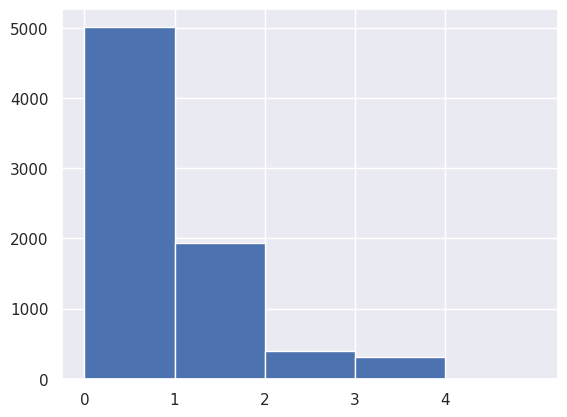

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
plt.rcParams['font.size'] = 10
plt.hist(imdb["train"]["labels"], bins=[0, 1, 2, 3, 4, 5]);
plt.xticks(range(0, 5))

plt.show()

as we can see, the data is very imbalanced. For this reason, we will try to downsample the majority classes 0 and 1 and see if we can obtain better results.

In [ ]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-german-cased", padding=True, trunctuation=True)

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_imdb = imdb.map(preprocess_function, batched=True)

In [ ]:
input_ids = tokenized_imdb['train']['input_ids']
attention_mask = tokenized_imdb['train']['attention_mask']
labels = tokenized_imdb['train']['labels']

In [ ]:
X = np.column_stack((input_ids, attention_mask))  # Stack them horizontally
y = np.array(labels)
X[0]

We will use RandomUnderSampler from imblearn to downsample the majority class.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy={0: 1500, 1: 1300})
X_res, y_res = rus.fit_resample(X, y)
X_res[0]

In [ ]:
input_ids_resampled = X_res[:, :len(input_ids[0])]
attention_mask_resampled = X_res[:, :len(input_ids[0])]
attention_mask_resampled[0]

In [ ]:
# De-nest the resampled lists
input_ids_resampled = [list(arr[0]) for arr in input_ids_resampled]
attention_mask_resampled = [list(arr[0]) for arr in attention_mask_resampled]


In [ ]:
from datasets import Dataset

dataset_resampled = Dataset.from_dict({
    'input_ids': input_ids_resampled,
    'attention_mask': attention_mask_resampled,
    'labels': y_res,
    'text': ['' for _ in range(len(y_res))]
})


In [ ]:
input_ids_resampled_list = [list(arr) for arr in input_ids_resampled]
attention_mask_resampled_list = [list(arr) for arr in attention_mask_resampled]
print(type(input_ids_resampled_list), type(input_ids_resampled_list[0]))  # should both be <class 'list'>
print(len(input_ids_resampled_list), len(input_ids_resampled_list[0]))  # should match your dataset's dimensions



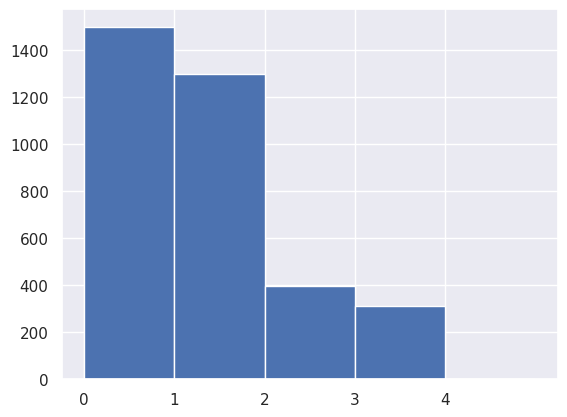

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
plt.rcParams['font.size'] = 10
plt.hist(dataset_resampled["labels"], bins=[0, 1, 2, 3, 4, 5]);
plt.xticks(range(0, 5))

plt.show()

as can be seen in above plot, we have successfuly downsampled the classes 0 and 1. They are still far larger than classes 2 and 3, but the imbalance has been reduced. 

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
!pip install evaluate

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

We also tried to improve our models performance by specifying the weights of each class and using a custom trainer. This is currently not implemented in below training session, but was tried in a previous step with lesser results ...

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(dataset_resampled["labels"]), y=imdb["train"]["labels"])
class_wts

array([0.38165503, 0.98914729, 4.82115869, 6.19417476])

In [ ]:
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-german-cased", num_labels=4
)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    print("using GPU")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

using GPU


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
torch.tensor(weights)

Below, the custom trainer that uses our pre-specified weights can be found. Please note that this is currently not being used in the Trainer. 

In [ ]:
from torch import nn
from transformers import Trainer


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
dataset_resampled["input_ids"]

In [ ]:
tokenized_imdb["validation"]["input_ids"]

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/Colab/Uni/HS23/EITASP/trial3_weighted",
    learning_rate=1e-5, 
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,  
    num_train_epochs=4, 
    weight_decay=0.01,  
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_resampled,
    eval_dataset=tokenized_imdb["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.209000,0.891294,0.682382
2,1.133200,0.932970,0.538462
3,1.063700,0.943634,0.523573
4,0.996500,0.932170,0.553350


TrainOutput(global_step=3508, training_loss=1.0911002583215554, metrics={'train_runtime': 249.7832, 'train_samples_per_second': 56.145, 'train_steps_per_second': 14.044, 'total_flos': 321211781194752.0, 'train_loss': 1.0911002583215554, 'epoch': 4.0})

In [ ]:
trainer.save_model("/content/drive/My Drive/Colab/Uni/HS23/EITASP/model")

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    "/content/drive/My Drive/Colab/Uni/HS23/EITASP/trial3_weighted/checkpoint-1743", num_labels=4
)

In [ ]:
validation_list = imdb["validation"]["text"]
test_list = imdb["test"]["text"]

In [ ]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=1)

In [ ]:
pred_test_list = pipe(test_list)

In [ ]:
pred_test_list

[[{'label': 'LABEL_0', 'score': 0.428449422121048}],
 [{'label': 'LABEL_0', 'score': 0.7091008424758911}],
 [{'label': 'LABEL_3', 'score': 0.3205927610397339}],
 [{'label': 'LABEL_0', 'score': 0.5622480511665344}],
 [{'label': 'LABEL_1', 'score': 0.48866117000579834}],
 [{'label': 'LABEL_0', 'score': 0.5332952737808228}],
 [{'label': 'LABEL_1', 'score': 0.4850786626338959}],
 [{'label': 'LABEL_0', 'score': 0.6197673678398132}],
 [{'label': 'LABEL_1', 'score': 0.6065195798873901}],
 [{'label': 'LABEL_0', 'score': 0.5757019519805908}],
 [{'label': 'LABEL_0', 'score': 0.44127506017684937}],
 [{'label': 'LABEL_0', 'score': 0.5821191072463989}],
 [{'label': 'LABEL_1', 'score': 0.5237653255462646}],
 [{'label': 'LABEL_0', 'score': 0.7138197422027588}],
 [{'label': 'LABEL_0', 'score': 0.6834726929664612}],
 [{'label': 'LABEL_0', 'score': 0.610395610332489}],
 [{'label': 'LABEL_1', 'score': 0.49330881237983704}],
 [{'label': 'LABEL_0', 'score': 0.5261955261230469}],
 [{'label': 'LABEL_1', 'sco